# Udara Peiris' calibration

## Packages

In [76]:
import requests
import pandas as pd
import os
import numpy as np

from scipy.optimize import fsolve
import matplotlib.pyplot as plt

## Path and working directory

In [77]:
ROOT = os.path.dirname(os.getcwd())

PATH_DATA = os.path.join(ROOT, 'data')

print(PATH_DATA)

c:\Users\Maude\OneDrive\Documents\etudes\UZH\PhD\2nd year\first semester\calibration in macroeconomics\project\Udara\data


## External estimation of parameters

### GDP growth

5-year GDP growth based on annual GDP per capita in Argentina from the World Bank

In [78]:
# open excel file

df_GDP = pd.read_excel(os.path.join(PATH_DATA, 'GDP_per_capita - Argentina - WB.xlsx'))

#clean database

## delete the last 5 rows because only NaN values
df_GDP = df_GDP.iloc[:-5]

## delete the columns from 1960 to 1982
columns_to_drop = [f"{year} [YR{year}]" for year in range(1960, 1983)]
df_GDP = df_GDP.drop(columns=columns_to_drop)

## convert from wide format to long format
df_long = pd.melt(df_GDP, id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')

## delete the first three columns because useless information as only one country and one variable
df_long = df_long.drop(columns=['Country Name', 'Series Name'])

## delete the first two rows because useless information as only one country and one variable
df_long = df_long.iloc[2:]

## rename the column 'Value' to 'GDP per capita'
df_long = df_long.rename(columns={'Value': 'GDP per capita'})

## change the format of the 'Year' variable
df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})').astype(int)

## create the 'GDP_growth_5' variable
df_long['GDP_growth_5'] = (df_long['GDP per capita'] - df_long['GDP per capita'].shift(5)) / df_long['GDP per capita'].shift(5)

# compute the 25th and 75th percentiles of the 'GDP_growth_5' variable between 1988 and 2001
## Filter the DataFrame for the years between 1988 and 2001
df_filtered = df_long[(df_long['Year'] >= 1988) & (df_long['Year'] <= 2001)]

## Create a vector with the GDP_growth_5 values
gdp_growth_5_vector = df_filtered['GDP_growth_5'].dropna().values

## Calculate the 25th and 75th percentiles
percentile_25 = np.percentile(gdp_growth_5_vector, 25)
percentile_75 = np.percentile(gdp_growth_5_vector, 75)

# Print the percentiles
print(f"the 25th percentile of the 5 year GDP growth between 1988 and 2001: {percentile_25}")
print(f"the 75th percentile of the 5 year GDP growth between 1988 and 2001: {percentile_75}")



the 25th percentile of the 5 year GDP growth between 1988 and 2001: 0.047384516851069064
the 75th percentile of the 5 year GDP growth between 1988 and 2001: 0.6934000884280214


## Calibration: Internal Estimation of Parameter

I will calibrate the bargaining power of the sovereign θ


In [79]:
# Initialization of external parameters
   
beta = 0.82                      # time discount factor
sigma = 2                        # risk aversion coefficient
g_l = percentile_25/100          # growth rate of the low state
g_h = percentile_75/100          # growth rate of the high state (should take evidence from countries doing well)
y_0 = 1                          # output in time 0
y_l = 1+g_l                      # output of the low state
y_h = 1+g_h                      # output of the high state
kappa = 0.2                      # loss of output if default (2% was too low for the Nash bargaining problem)

In [80]:
# Creation of grid for the believed haircut and for the bargaining power

delta_b = np.linspace(0, 1, 11) # to change later for 101 instead of 11
theta = np.linspace(0, 1, 11)

### Solving Household Problem

In [81]:
# price in time 0, q_0
q_0 = beta*(1-delta_b/2)

In [82]:
# price in time 1, q_1
q_1 = beta
q_1

0.82

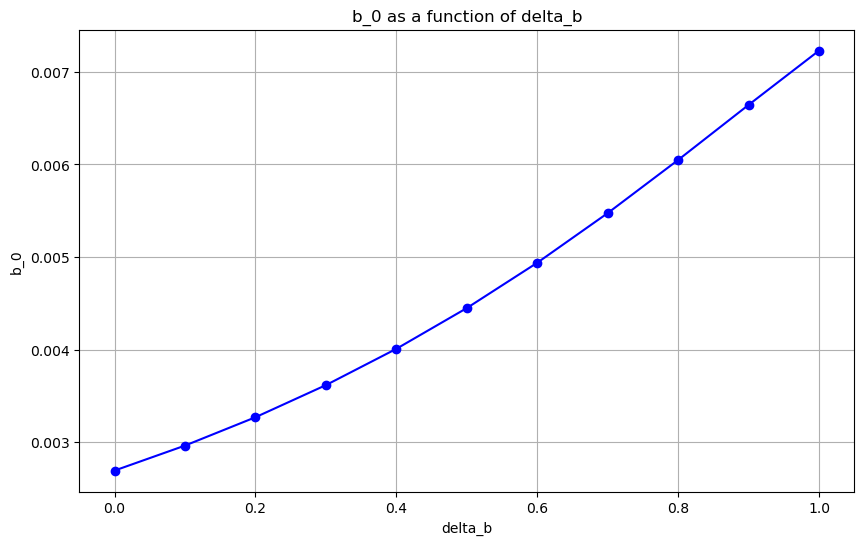

In [83]:
# solve for b_0

def HH_foc_b0(b_0, delta_b, q_0):
    LHS = (2-delta_b)*(y_0 + q_0*b_0 )**(-sigma)
    RHS_1 = (1-delta_b)*(y_l + beta*(1-delta_b)/(1+beta)*b_0 - (1-delta_b)*b_0)**(-sigma)
    RHS_2 = (y_h-b_0/(1+beta))**(-sigma)
    return LHS - RHS_1 - RHS_2

# Initial guess for the root
initial_guess = 0.5

# Vectorized function to solve for the root for each combination of delta_b and q_0
def solve_for_roots(delta_b, q_0, initial_guess):
    # Define a wrapper function for fsolve that only takes b_0 as input
    def wrapper(delta_b, q_0):
        return fsolve(HH_foc_b0, initial_guess, args=(delta_b, q_0))[0]
    
    # Apply the wrapper function to each combination of delta_b and q_0
    b_0 = np.array([wrapper(delta_b, q_0) for delta_b, q_0 in zip(delta_b, q_0)])
    return b_0

# Solve for the roots
b_0 = solve_for_roots(delta_b, q_0, initial_guess)
b_0

# Plot b_0 as a function of delta_b
plt.figure(figsize=(10, 6))
plt.plot(delta_b, b_0, marker='o', linestyle='-', color='b')
plt.xlabel('delta_b')
plt.ylabel('b_0')
plt.title('b_0 as a function of delta_b')
plt.grid(True)
plt.show()

    


In [84]:
# consumption in time 0, c_0

c_0 = y_0 + q_0*b_0
c_0

array([1.00220849, 1.0023082 , 1.00241254, 1.00252019, 1.00262889,
       1.00273513, 1.00283364, 1.00291693, 1.00297494, 1.0029951 ,
       1.00296309])

### Solving Nash Bargaining

In [85]:
# utility function

def utility(c):
    return c**(1-sigma)/(1-sigma)

utility(0.5)



-2.0

In [127]:
# omega function

def omega(delta_l, theta, b_0):
    HS = ((1+beta)*utility(y_l - (1-delta_l)/(1+beta)*b_0)-utility(y_l)-beta*utility((1-kappa)*y_l))**theta
    FS = (b_0*(1-delta_l))**(1-theta)
    return HS*FS

# grid for delta_l and theta
delta_l = np.linspace(0, 1, 11)
theta_b = np.linspace(0, 1, 11)

#create a meshgrid for delta_l and theta
delta_L, theta_B, B_0 = np.meshgrid(delta_l, theta_b, b_0)

# matrix for omega
m_omega = omega(delta_L, theta_B, B_0)

# Find the highest value for each combination of theta_B and B_0

## Not sure about which axis to use -> axis = 0 seems more intuitive, but axis = 1 seems to give the correct result

max_indices = np.argmax(m_omega, axis=1) 

# Convert indices to corresponding delta_L values
max_delta_L_values = delta_l[max_indices]

print(max_delta_L_values)
theta_B

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


array([[[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        ...,
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]],

       [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],

       ...,

       [[0.8, 0.8, 0.8, ..., 0.8, 0.8, 0.8],
        [0.8, 0.8, 0.8, ..., 0.8, 0.8, 0.8],
        [0.8, 0.8, 0.8, ..., 0.8, 0.8, 0.8